# Gemini pass/maj-at-k experiments

Run Gemini 1.5 Pro v2 with temperature 1 and top_p 0.95, sampling 64 times. Used zero-shot prompt (short answer) and got 8 completions at seeds 0-7 (as each call supports at most 8 completions). These samples are then used to compute pass@k and maj@k results for powers of 2 from 1 to 64.

WARNING: Some of these cells, i.e. answer checking and maj@ sampling, take quite some time!

In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.api import safe_unified_api_call
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.prompt import create_prompt
from eval.prompts import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

In [5]:
def make_results_passk_df(response_map, answer_check_results, dataset_map, mode="shortans"):
    results_metadata = []
    for idx, acr in enumerate(answer_check_results):
        split = acr["uid"].split('/')[-1].split('_')
        if len(split) == 1:
            p_uid = acr["uid"]
            gen_num = 0
        else:
            p_uid = acr["uid"][:-len(split[-1])-1]
            gen_num = int(split[-1])
        problem = dataset_map[p_uid]
        resp = response_map[p_uid]
    
        # some problems may be fixed after running the eval, so this is to sanity check
        if mode == "shortans" and problem["multiple_choice_only"]:
            print(f"WARNING: found eval for mcq-only problem {resp['uid']}")
            continue
        elif mode == "mcq" and (problem["contest"].startswith("AIME") or problem["contest"].endswith("MO")):
            print(f"WARNING: found eval for non-mcq contest problem {resp['uid']}")
            continue
        
        level = problem["level"]
        subject = problem["subject"]
        has_asy_problem = "[asy]" in problem["problem"]
        has_asy_solution = "[asy]" in problem["solution_1"]  # only look at first solution for now
        reason = resp["response"].completions[gen_num].finish_reason.value
        usage = resp["response"].usage
        results_metadata.append({
            "uid": acr["uid"],
            "p_uid": p_uid,
            "gen_num": gen_num,
            "level": level,
            "subject": subject,
            "mcq_only": problem["multiple_choice_only"],
            "has_asy_problem": has_asy_problem,
            "has_asy_solution": has_asy_solution,
            "reason": reason,
            "is_correct": acr["is_correct"],
            "answer": acr["answer"],
            "predict": acr["predict"],
        })
    results_metadata = pd.DataFrame(results_metadata).set_index("uid")
    return results_metadata

In [6]:
fname_template = BASEDIR / "outputs/short_answer/gemini-1.5-pro-002/outputs_passk_seed{seed}.jsonl"
raw_response_map = dict()
for seed in range(8):
    # print("*************************")
    # print("seed", seed)
    fname = str(fname_template).format(seed=seed)
    for resp in read_jsonl(fname):
        if resp["custom_id"] in raw_response_map:
            curr = raw_response_map[resp["custom_id"]]
            assert curr["response"]["modelVersion"] == resp["response"]["modelVersion"]
            for k, v in resp["response"]["usageMetadata"].items():
                curr["response"]["usageMetadata"][k] += v
            curr["response"]["candidates"].extend(resp["response"]["candidates"])
        else:
            raw_response_map[resp["custom_id"]] = resp

In [ ]:
responses = [
    {
        "uid": x["custom_id"],
        "system": x["request"]["system_instruction"],
        "prompt": x["request"]["contents"],
        "response": ModelResponse.from_response(x["response"], "google", use_batch_api=True)
    }
    for x in raw_response_map.values()
    if x["custom_id"] in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
# answer_check_results = []
# for prob in tqdm(answer_check_dicts):
#     # If the generation didn't finish or otherwise failed, then we should mark as "incorrect"
#     # Note that otherwise we might take a random value as the "answer" for a generation that hit max tokens
#     model_ans = prob["generated_text"] if prob["finish_reason"] == "stop" else None
#     gt = prob["answer"]
#     out = run_with_timeout(check_one_latex_answer,
#                            10
#                             model_ans,
#                             gt,
#                             extract_policy="flex",
#                             eval_policy="aggressive",
#                         )
#     answer_check_results.append({**prob, **out})

In [22]:
results_metadata = make_results_passk_df(response_map, answer_check_results, dataset_map)

In [24]:
results_metadata.to_csv(BASEDIR / "results/gemini-1.5-pro-002_passk/results.csv")

In [6]:
results_metadata = pd.read_csv(BASEDIR / "results/gemini-1.5-pro-002_passk/results.csv").set_index("uid")

In [7]:
len(results_metadata)

305920

In [9]:
results_metadata.value_counts("reason")

reason
stop         305619
copyright       301
Name: count, dtype: int64

In [10]:
def get_problem_uid(resp_uid):
    p_uid = resp_uid.split("/")
    return "/".join([*p_uid[:-1], p_uid[-1].split("_")[0]])

def get_gen_num(resp_uid):
    p_uid = resp_uid.split("/")
    if "_" not in p_uid[-1]:
        return 0
    else:
        return int(p_uid[-1].split("_")[1])

results_metadata["p_uid"] = [get_problem_uid(uid) for uid in results_metadata.index]
results_metadata["gen_num"] = [get_gen_num(uid) for uid in results_metadata.index]
results_metadata = results_metadata.set_index(["p_uid", "gen_num"])

In [11]:
list(results_metadata.loc[('2023/AMC_8/18')].predict)

['411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '659',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '747',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '674',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '406',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '595',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411',
 '411']

In [12]:
results_metadata.loc[('2023/AMC_8/18')]['is_correct'].mean()

np.float64(0.921875)

## Accuracy

In [13]:
results_metadata["is_correct"].mean()

np.float64(0.5726366370292887)

In [14]:
results_metadata.groupby("p_uid")["is_correct"].mean().sort_values(ascending=False).head(10)

p_uid
1950/AHSME/22     1.0
2005/AMC_8/25     1.0
2005/AMC_8/4      1.0
2005/AMC_8/9      1.0
2005/AMC_12B/7    1.0
2005/AMC_12B/8    1.0
2005/AMC_12B/9    1.0
2005/AMC_8/1      1.0
2005/AMC_8/10     1.0
1951/AHSME/37     1.0
Name: is_correct, dtype: float64

In [15]:
results_metadata.groupby("p_uid")["is_correct"].mean().sort_values(ascending=False).loc["1950/AHSME/1"]

np.float64(1.0)

<Axes: >

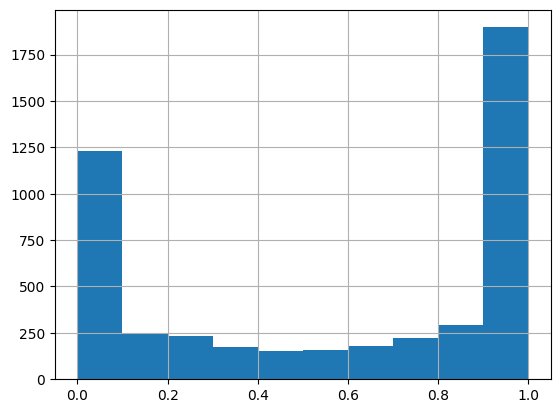

In [16]:
results_metadata.groupby("p_uid")["is_correct"].mean().hist()

In [17]:
(results_metadata.groupby("p_uid")["is_correct"].sum() == 0).sum()

np.int64(682)

### pass@k

In [18]:
def compute_pass_at_k(df, k):
    if k > 64:
        raise ValueError("We only have 64 samples")
    return (
        df
        .groupby("p_uid")
        ["is_correct"].apply(lambda x: 1 - math.comb(64-x.sum(), k)/math.comb(64, k))
    )

In [19]:
pass_at_accuracies = []
for e in range(0, 7):
    k = 2 ** e
    pass_acc = compute_pass_at_k(results_metadata, k=k).mean()
    print(f"pass@{k} accuracy: {100 * pass_acc:.02f}")
    pass_at_accuracies.append(pass_acc)

pass@1 accuracy: 57.26
pass@2 accuracy: 64.88
pass@4 accuracy: 71.02
pass@8 accuracy: 76.02
pass@16 accuracy: 80.03
pass@32 accuracy: 83.23
pass@64 accuracy: 85.73


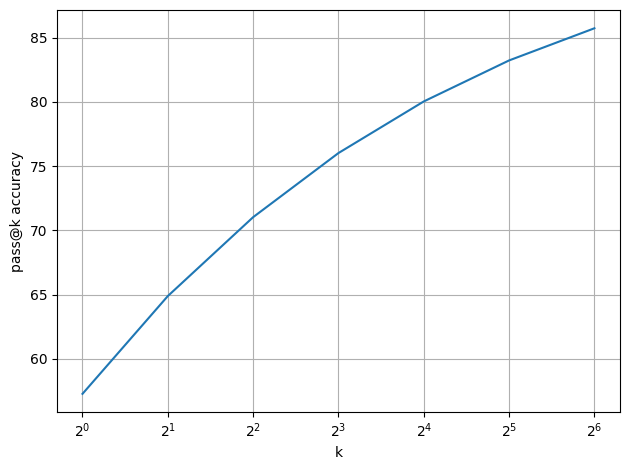

In [20]:
plt.plot([2**e for e in range(0,7)], [acc*100 for acc in pass_at_accuracies])

plt.xscale("log", base=2)
# plt.title("Pass@k performance")
plt.xlabel("k")
plt.ylabel("pass@k accuracy")
plt.grid(True)
# plt.show()
plt.tight_layout()
plt.savefig(BASEDIR / '../images/gemini_passk.pdf')

### maj@k

Sympy answer checker often hangs.. let's add a timeout

In [21]:
NUM_MAJK_SAMPLES = 5

In [120]:
# import signal

# # Custom exception for handling the timeout
# class TimeoutException(Exception):
#     pass

# # Function to handle the timeout signal
# def timeout_handler(signum, frame):
#     raise TimeoutException("Execution timed out!")

# # Function to run with a timeout
# def run_with_timeout(func, timeout_seconds, *args, **kwargs):
#     # Set the signal handler for the SIGALRM signal
#     signal.signal(signal.SIGALRM, timeout_handler)
#     # Start the timer
#     signal.alarm(timeout_seconds)

#     try:
#         # Call the function
#         result = func(*args, **kwargs)
#         # Disable the alarm after success
#         signal.alarm(0)
#         return result
#     except TimeoutException as e:
#         print(args)
#         print(e)
#     finally:
#         # Ensure that the alarm is disabled after the execution
#         signal.alarm(0)

In [138]:
# def _compute_majk(p_df):
#     maj_results = []
#     for n_sample in range(NUM_MAJK_SAMPLES):
#         sample_maj_results = {}
        
#         answer_subsets = []
#         subset_to_correct = []
        
#         df_sample = p_df.sample(frac=1)
#         for row_idx, row in enumerate(df_sample.itertuples()):
#             predict = row.predict
#             if predict is not None:
#                 for existing_subset in answer_subsets:
#                     check_response = run_with_timeout(check_one_latex_answer, 5, str(predict), str(existing_subset[0]), extract_policy="none")
#                     if check_response:
#                         if check_response['is_correct']:
#                             existing_subset.append(predict)
#                             break
# #                     if run_with_timeout(check_one_latex_answer, 10, str(predict), str(existing_subset[0]), extract_policy="none")["is_correct"]:
# #                         existing_subset.append(predict)
# #                         break
#                 else:
#                     answer_subsets.append([predict])
#                     subset_to_correct.append(row.is_correct)

#             if row_idx+1 in [1, 2, 4, 8, 16, 32, 64]:
#                 # print("row_idx + 1 =", row_idx+1)
#                 max_length = -1
#                 max_length_corrects = []
#                 for ss_idx, subset in enumerate(answer_subsets):
#                     if len(subset) > max_length:
#                         max_length = len(subset)
#                         max_length_corrects = [subset_to_correct[ss_idx]]
#                     elif len(subset) == max_length:
#                         max_length_corrects.append(subset_to_correct[ss_idx])
#                 maj_acc = sum(max_length_corrects) / len(max_length_corrects)
#                 sample_maj_results[row_idx+1] = maj_acc
#         maj_results.append(sample_maj_results)
#     return pd.DataFrame(maj_results)

# def compute_maj_at(df):
#     return (
#         df
#         .groupby("p_uid")
#         [["predict", "is_correct"]].progress_apply(lambda x: _compute_majk(x))
#         .reset_index()
#         .drop(columns=["level_1"])
#         .set_index("p_uid")
#     )

In [139]:
# len(results_metadata.groupby("p_uid"))

4781

In [140]:
# np.random.seed(10)
# maj_at_df = []
# for p_uid, subdf in tqdm(results_metadata.groupby("p_uid")[["predict", "is_correct"]]):
#     maj_at_df.append(_compute_majk(subdf).assign(p_uid=p_uid).set_index("p_uid"))

  0%|          | 0/4781 [00:00<?, ?it/s]

In [141]:
# len(maj_at_df)

4781

In [144]:
# maj_at_df = pd.concat(maj_at_df)
# maj_at_df.head()

,1,2,4,8,16,32,64
p_uid,,,,,,,
1950/AHSME/1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1950/AHSME/1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# maj_at_df.mean()

1     0.522380
2     0.523332
4     0.562571
8     0.585644
16    0.597689
32    0.605094
64    0.609428
dtype: float64

In [151]:
# maj_at_df.to_csv(BASEDIR / 'results/gemini-1.5-pro-002_passk/majk.csv')

In [22]:
maj_at_df = pd.read_csv(BASEDIR / 'results/gemini-1.5-pro-002_passk/majk.csv').set_index('p_uid')

In [24]:
maj_at_df.head(10)

,1,2,4,8,16,32,64
p_uid,,,,,,,
1950/AHSME/1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/10,1.0,0.5,1.0,1.0,1.0,1.0,1.0
1950/AHSME/10,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/10,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1950/AHSME/10,0.0,0.5,1.0,1.0,1.0,1.0,1.0


In [25]:
# Drop calculus problems post-eval
maj_at_df = maj_at_df[maj_at_df.index.isin(dataset_map.keys())]

In [26]:
len(maj_at_df.index.unique())

4780

In [27]:
maj_at_df_by_ordering = [maj_at_df.iloc[i::NUM_MAJK_SAMPLES] for i in range(NUM_MAJK_SAMPLES)]

In [30]:
from scipy import stats
t_value = stats.t.ppf((1 + 0.95) / 2, NUM_MAJK_SAMPLES-1)
t_value

np.float64(2.7764451051977987)

[0.57192469 0.57374477 0.61709205 0.64117852 0.6523607  0.66017233
 0.6631311 ] [0.00268892 0.00314939 0.00297897 0.00152013 0.00170983 0.00080563
 0.00011459]


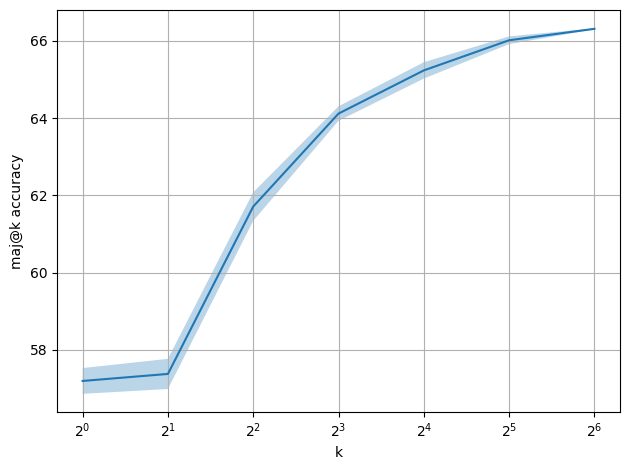

In [31]:
maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i].mean()) for i in range(NUM_MAJK_SAMPLES)])
mean = np.mean(maj_at_per_ordering, axis=0)
std = np.std(maj_at_per_ordering, axis=0, ddof=1)
print(mean, std)

plt.fill_between([2**e for e in range(0,7)], 100*(mean-t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), 
                 100*(mean+t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), alpha=0.3)
plt.plot([2**e for e in range(0,7)], 100*mean)

plt.xscale("log", base=2)
# plt.title("Pass@k performance")
plt.xlabel("k")
plt.ylabel("maj@k accuracy")
plt.grid(True)
# plt.show()
plt.tight_layout()
plt.savefig(BASEDIR / '../images/gemini_majk.pdf',bbox_inches='tight')

## Merged plots

First, we'll try making one with two subplots: pass@ and maj@ for the full dataset, and then for just the hardest levels

In [32]:
pass_at_accuracies = []
for e in range(0, 7):
    k = 2 ** e
    pass_acc = compute_pass_at_k(results_metadata, k=k).mean()
    print(f"pass@{k} accuracy: {100 * pass_acc:.02f}")
    pass_at_accuracies.append(pass_acc)

pass@1 accuracy: 57.26
pass@2 accuracy: 64.88
pass@4 accuracy: 71.02
pass@8 accuracy: 76.02
pass@16 accuracy: 80.03
pass@32 accuracy: 83.23
pass@64 accuracy: 85.73


In [33]:
results_metadata[results_metadata['level'] >= 5]

level                   subject  mcq_only  \
p_uid          gen_num                                              
2023/AIME_I/14 0            6                  geometry     False   
               1            6                  geometry     False   
               2            6                  geometry     False   
               3            6                  geometry     False   
               4            6                  geometry     False   
...                       ...                       ...       ...   
2017/AIME_I/11 59           5  counting_and_probability     False   
               60           5  counting_and_probability     False   
               61           5  counting_and_probability     False   
               62           5  counting_and_probability     False   
               63           5  counting_and_probability     False   

                        has_asy_problem  has_asy_solution reason  is_correct  \
p_uid          gen_num                                                         
2023/AIME_I/14 0                   True              True   stop       False   
               1                   True              True   stop       False   
               2                   True              True   stop       False   
               3                   True              True   stop       False   
               4                   True              True   stop       False   
...                                 ...               ...    ...         ...   
2017/AIME_I/11 59                 False             False   stop       False   
               60                 False             False   stop       False   
               61                 False             False   stop       False   
               62                 False             False   stop       False   
               63                 False             False   stop       False   

                       answer predict  
p_uid          gen_num                 
2023/AIME_I/14 0        $608$       2  
               1        $608$     936  
               2        $608$     840  
               3        $608$     256  
               4        $608$      72  
...                       ...     ...  
2017/AIME_I/11 59       $360$     512  
               60       $360$   31104  
               61       $360$    1728  
               62       $360$     296  
               63       $360$     184  

[25216 rows x 9 columns]

In [34]:
maj_levels = np.array([results_metadata.loc[(p, 0)]['level'] 
                       for p in maj_at_df_by_ordering[0].index])

pass@1 accuracy: 57.26
pass@2 accuracy: 64.88
pass@4 accuracy: 71.02
pass@8 accuracy: 76.02
pass@16 accuracy: 80.03
pass@32 accuracy: 83.23
pass@64 accuracy: 85.73
pass@1 accuracy: 15.04
pass@2 accuracy: 21.64
pass@4 accuracy: 28.75
pass@8 accuracy: 35.89
pass@16 accuracy: 42.69
pass@32 accuracy: 48.87
pass@64 accuracy: 54.57


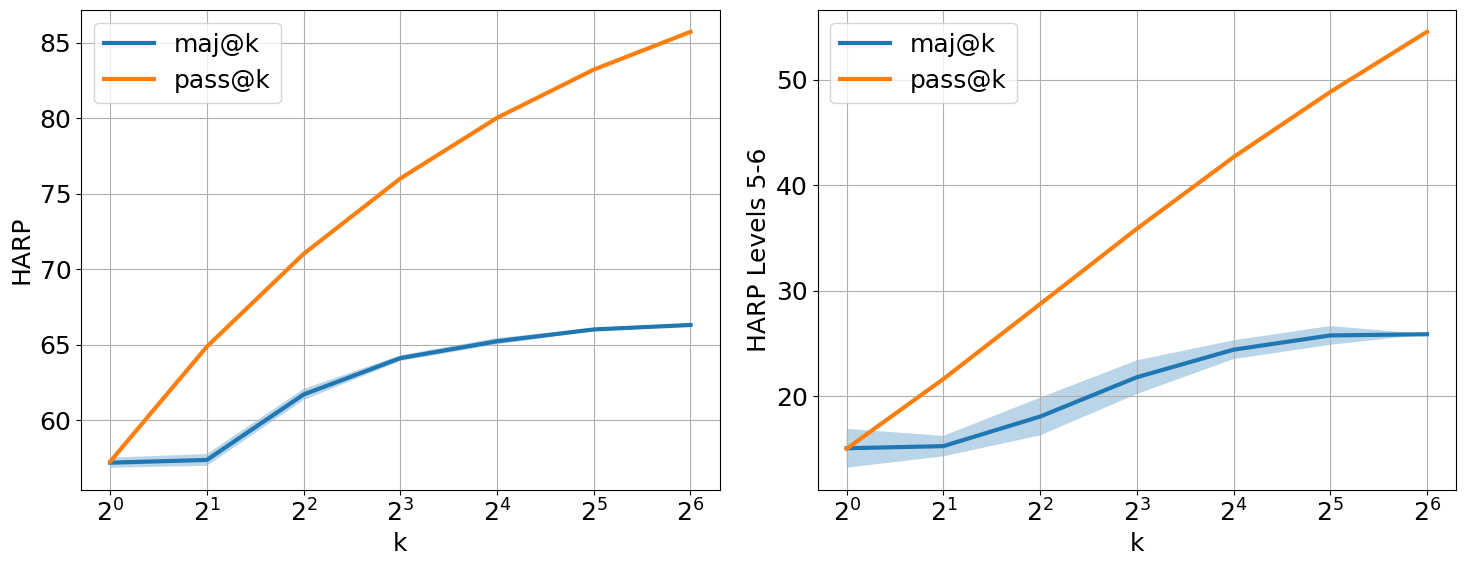

In [35]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,2, sharex=True)
fig.set_size_inches(15,6)

## Full dataset
maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i].mean()) for i in range(NUM_MAJK_SAMPLES)])
mean = np.mean(maj_at_per_ordering, axis=0)
std = np.std(maj_at_per_ordering, axis=0, ddof=1)

axs[0].fill_between([2**e for e in range(0,7)], 100*(mean-t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), 
                 100*(mean+t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), alpha=0.3)
axs[0].plot([2**e for e in range(0,7)], 100*mean, label='maj@k', lw=3)

pass_at_accuracies = []
for e in range(0, 7):
    k = 2 ** e
    pass_acc = compute_pass_at_k(results_metadata, k=k).mean()
    print(f"pass@{k} accuracy: {100 * pass_acc:.02f}")
    pass_at_accuracies.append(pass_acc)
axs[0].plot([2**e for e in range(0,7)], [acc*100 for acc in pass_at_accuracies],
            label='pass@k', lw=3)

axs[0].set_xscale("log", base=2)
axs[0].set_xlabel("k")
axs[0].set_ylabel("HARP")
axs[0].legend()
axs[0].grid(True)

## Hard dataset
maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i][maj_levels >= 5].mean()) for i in range(NUM_MAJK_SAMPLES)])
mean = np.mean(maj_at_per_ordering, axis=0)
std = np.std(maj_at_per_ordering, axis=0, ddof=1)

axs[1].fill_between([2**e for e in range(0,7)], 100*(mean-t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), 
                 100*(mean+t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), alpha=0.3)
axs[1].plot([2**e for e in range(0,7)], 100*mean, label='maj@k', lw=3)

pass_at_accuracies = []
for e in range(0, 7):
    k = 2 ** e
    pass_acc = compute_pass_at_k(results_metadata[results_metadata['level'] >= 5], k=k).mean()
    print(f"pass@{k} accuracy: {100 * pass_acc:.02f}")
    pass_at_accuracies.append(pass_acc)
axs[1].plot([2**e for e in range(0,7)], [acc*100 for acc in pass_at_accuracies], 
            label='pass@k', lw=3)

axs[1].set_xscale("log", base=2)
axs[1].set_xlabel("k")
axs[1].set_ylabel("HARP Levels 5-6")
axs[1].legend()
axs[1].grid(True)

# plt.show()
plt.tight_layout()
fig.savefig(BASEDIR / '../images/gemini_passk_majk_comp_v1.pdf')

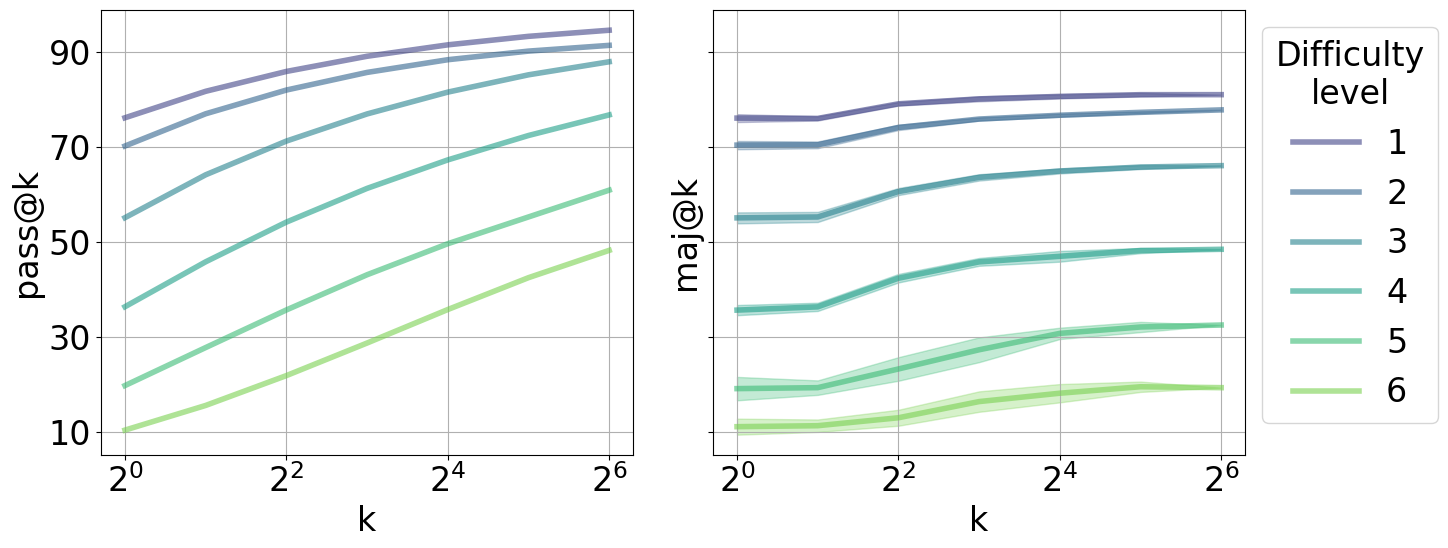

In [38]:
matplotlib.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(15,6)

colors = plt.get_cmap('viridis')(np.linspace(0.2, 0.8, 6))
colors[:, -1] = 0.6

for i, difficulty in enumerate(range(1, 7)):
    ## pass@
    pass_at_accuracies = []
    for e in range(0, 7):
        k = 2 ** e
        pass_acc = compute_pass_at_k(results_metadata[results_metadata['level'] == difficulty], k=k).mean()
        pass_at_accuracies.append(pass_acc)
    axs[0].plot([2**e for e in range(0,7)], [acc*100 for acc in pass_at_accuracies],
                label=str(difficulty), lw=4, c=colors[i])
    
    maj_at_per_ordering = np.array([list(maj_at_df_by_ordering[i][maj_levels == difficulty].mean()) for i in range(NUM_MAJK_SAMPLES)])
    mean = np.mean(maj_at_per_ordering, axis=0)
    std = np.std(maj_at_per_ordering, axis=0, ddof=1)

    axs[1].fill_between([2**e for e in range(0,7)], 100*(mean-t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), 
                     100*(mean+t_value*std/np.sqrt(NUM_MAJK_SAMPLES)), alpha=0.3, color=colors[i])
    axs[1].plot([2**e for e in range(0,7)], 100*mean, label=str(difficulty), lw=4, c=colors[i])
    
for i in range(2):
    axs[i].set_xscale("log", base=2)
    axs[i].set_xlabel("k")
    axs[i].grid(True)

axs[0].set_ylabel("pass@k")
axs[0].set_yticks([10, 30, 50, 70, 90])
axs[0].set_xticks([1, 4, 16, 64])
axs[1].set_ylabel("maj@k")
axs[1].legend(title='Difficulty\nlevel', bbox_to_anchor=(1,1), loc='upper left').get_title().set_multialignment('center')
# plt.show()
plt.tight_layout()
fig.savefig(BASEDIR / '../images/gemini_passk_majk_comp_v2.pdf', bbox_inches='tight')